<a href="https://colab.research.google.com/github/NahinAlam001/499B/blob/SAM/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import subprocess

def install(package):
    subprocess.check_call(["pip", "install", package])

def main():
    # Install standard packages
    packages = [
        "monai",
        "datasets",
        "scikit-learn",
        "fvcore",
    ]

    for package in packages:
        install(package)

    # Install packages from GitHub
    git_packages = [
        "git+https://github.com/facebookresearch/segment-anything.git",
        "git+https://github.com/huggingface/transformers.git"
    ]

    for git_package in git_packages:
        install(git_package)

    print("All dependencies have been installed successfully!")

if __name__ == "__main__":
    main()

In [ ]:
import os
import zipfile
import subprocess

def download_dataset():
    subprocess.run(["gdown", "https://drive.google.com/uc?id=1FomR78IlcqHqNi77fXAJCMgvEebihhF-"])

def extract_dataset(zip_file, extract_to="."):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

if __name__ == "__main__":

    # Download the dataset
    download_dataset()

    # Extract the dataset
    extract_dataset('Dataset.zip')

In [6]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from statistics import mean
from transformers import SamProcessor, SamModel, SamImageProcessor

# Paths
images_dir = "/content/Dataset/images"
masks_dir = "/content/Dataset/masks"
csv_file = "data.csv"
checkpoint_dir = "/content/checkpoints"

# Create checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Read the CSV to determine number of classes
data = pd.read_csv(csv_file)
num_classes = len(data['dx'].unique())

# Hyperparameters
batch_size = 4
learning_rate = 0.001
num_epochs = 100
accumulation_steps = 4

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Utility function to get bounding box
def get_bounding_box(ground_truth_map):
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        x_min, x_max, y_min, y_max = 0, 0, 0, 0
    else:
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    return [x_min, y_min, x_max, y_max]

# Custom dataset
class CustomImageItemDataset(Dataset):
    def __init__(self, images_dir, masks_dir, csv_file, transform=None, target_size=(256, 256)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.target_size = target_size
        unique_labels = self.data['dx'].unique()
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, f"{self.data.iloc[idx, 0]}.bmp")
        mask_name = os.path.join(self.masks_dir, f"{self.data.iloc[idx, 0]}_lesion.bmp")
        if not os.path.isfile(img_name) or not os.path.isfile(mask_name):
            raise ValueError(f"Image or mask file not found for index {idx}")
        image = cv2.imread(img_name)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise ValueError(f"Error loading image at {img_name}")
        if mask is None:
            raise ValueError(f"Error loading mask at {mask_name}")

        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
        _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        label_str = self.data.iloc[idx, 1]
        if label_str not in self.label_map:
            raise ValueError(f"Unknown label: {label_str}")

        label = self.label_map[label_str]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return {"image": image, "mask": mask, "label": label, "mask_name": mask_name}

# SAM Dataset
class SAMDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        mask_name = item["mask_name"]
        ground_truth_mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

        if ground_truth_mask is None:
            raise ValueError(f"Error loading mask at {mask_name}")

        ground_truth_mask = cv2.resize(ground_truth_mask, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            ground_truth_mask = self.transform(ground_truth_mask)

        ground_truth_mask = torch.tensor(ground_truth_mask, dtype=torch.float32).unsqueeze(0)
        prompt = get_bounding_box(ground_truth_mask.numpy().squeeze())
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt", do_rescale=False)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        inputs["label"] = item["label"]
        return inputs

# Model definition
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        self.densenet = models.densenet121(weights="IMAGENET1K_V1")
        self.densenet.features.conv0 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_processor = SamImageProcessor()
    processor = SamProcessor(image_processor)
    sam_model = SamModel.from_pretrained("facebook/sam-vit-base")
    sam_model = sam_model.to(device)
    dataset = CustomImageItemDataset(images_dir, masks_dir, csv_file, transform=transform)
    train_dataset = SAMDataset(dataset=dataset, processor=processor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
    classifier = DenseNetClassifier(num_classes=num_classes)
    classifier = classifier.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

    start_epoch = 0

    # Load checkpoint if available
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        classifier.load_state_dict(checkpoint['classifier_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Loaded checkpoint from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        epoch_losses = []
        classifier.train()
        sam_model.eval()  # Ensure SAM model is in evaluation mode
        for i, batch in enumerate(tqdm(train_loader)):
            images = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                sam_output = sam_model(images, input_boxes=None)
                pred_masks = sam_output["pred_masks"]  # Extract predicted masks

                # Squeeze the unnecessary dimension
                pred_masks = pred_masks.squeeze(1)  # Now shape is [batch_size, num_predictions, height, width]

                # Combine masks across channels
                pred_masks = pred_masks.permute(0, 2, 3, 1).reshape(pred_masks.shape[0], pred_masks.shape[2], pred_masks.shape[3], -1)

                pred_masks = pred_masks.permute(0, 3, 1, 2)  # Permute to match [batch_size, channels, height, width]
                pred_masks = pred_masks[:, :3, :, :]  # Select the first 3 channels

                # Resize pred_masks to match images dimensions
                pred_masks = torch.nn.functional.interpolate(pred_masks, size=(images.shape[2], images.shape[3]), mode='bilinear')

                combined_input = torch.cat((images, pred_masks), dim=1)  # Combine images and masks

            with torch.cuda.amp.autocast():
                outputs = classifier(combined_input)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_losses.append(loss.item())

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {mean(epoch_losses)}")

        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch,
                'classifier_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict()
}
torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved at epoch {epoch + 1}")

100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


Epoch 93/100, Loss: 0.6486119413375855


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Epoch 94/100, Loss: 0.6354011917114257


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Epoch 95/100, Loss: 0.6520820331573486


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Epoch 96/100, Loss: 0.6529144430160523


100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


Epoch 97/100, Loss: 0.6196100664138794


100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


Epoch 98/100, Loss: 0.689238737821579


100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


Epoch 99/100, Loss: 0.6774929308891297


100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


Epoch 100/100, Loss: 0.6850839614868164
Checkpoint saved at epoch 100


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
  0%|          | 0/50 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-20-015282bafacb>:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sour

Accuracy: 0.76
Precision: 0.7840, Recall: 0.7600, F1 Score: 0.7436


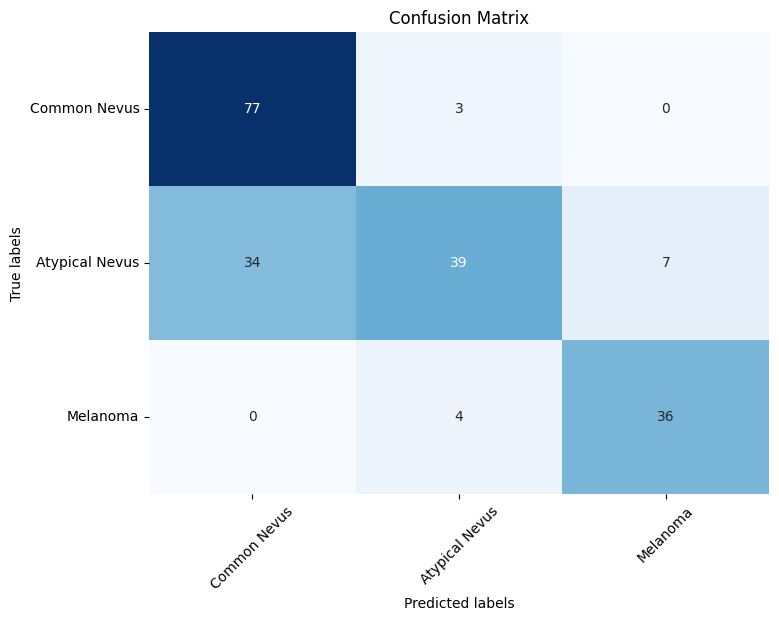

In [20]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from transformers import SamProcessor, SamModel, SamImageProcessor
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
images_dir = "/content/Dataset/images"
masks_dir = "/content/Dataset/masks"
csv_file = "data.csv"
checkpoint_path = "/content/drive/MyDrive/499B/checkpoint.pth"  # Adjust path to your checkpoint

# Read the CSV to determine number of classes
data = pd.read_csv(csv_file)
num_classes = len(data['dx'].unique())

# Data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# Custom dataset for evaluation
class CustomImageItemDataset(Dataset):
    def __init__(self, images_dir, masks_dir, csv_file, transform=None, target_size=(256, 256)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.target_size = target_size
        unique_labels = self.data['dx'].unique()
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, f"{self.data.iloc[idx, 0]}.bmp")
        mask_name = os.path.join(self.masks_dir, f"{self.data.iloc[idx, 0]}_lesion.bmp")
        if not os.path.isfile(img_name) or not os.path.isfile(mask_name):
            raise ValueError(f"Image or mask file not found for index {idx}")
        image = cv2.imread(img_name)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise ValueError(f"Error loading image at {img_name}")
        if mask is None:
            raise ValueError(f"Error loading mask at {mask_name}")

        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
        _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
        label_str = self.data.iloc[idx, 1]
        if label_str not in self.label_map:
            raise ValueError(f"Unknown label: {label_str}")

        label = self.label_map[label_str]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return {"image": image, "mask": mask, "label": label, "mask_name": mask_name}

# SAM Dataset for evaluation
class SAMDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        mask_name = item["mask_name"]
        ground_truth_mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

        if ground_truth_mask is None:
            raise ValueError(f"Error loading mask at {mask_name}")

        ground_truth_mask = cv2.resize(ground_truth_mask, (image.shape[2], image.shape[1]), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            ground_truth_mask = self.transform(ground_truth_mask)

        ground_truth_mask = torch.tensor(ground_truth_mask, dtype=torch.float32).unsqueeze(0)
        prompt = get_bounding_box(ground_truth_mask.numpy().squeeze())
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt", do_rescale=False)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = ground_truth_mask
        inputs["label"] = item["label"]
        return inputs

# Model definition
class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        self.densenet = models.densenet121(pretrained=False)
        self.densenet.features.conv0 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x

def plot_confusion_matrix(cm, class_names):
    """
    Plot a confusion matrix heatmap.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_processor = SamImageProcessor()
    processor = SamProcessor(image_processor)
    sam_model = SamModel.from_pretrained("Facebook/sam-vit-base")
    sam_model = sam_model.to(device)
    dataset = CustomImageItemDataset(images_dir, masks_dir, csv_file, transform=transform)
    eval_dataset = SAMDataset(dataset=dataset, processor=processor, transform=transform)
    eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, num_workers=2)

    # Initialize model and load checkpoint
    classifier = DenseNetClassifier(num_classes=num_classes)
    classifier = classifier.to(device)
    checkpoint = torch.load(checkpoint_path)

    # Modify checkpoint to adapt to current model
    classifier_dict = classifier.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['classifier_state_dict'].items() if k in classifier_dict}
    classifier_dict.update(pretrained_dict)
    classifier.load_state_dict(classifier_dict)

    classifier.eval()  # Set model to evaluation mode

    criterion = nn.CrossEntropyLoss()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(eval_loader):
            images = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            sam_output = sam_model(images, input_boxes=None)
            pred_masks = sam_output["pred_masks"]  # Extract predicted masks

            # Squeeze the unnecessary dimension
            pred_masks = pred_masks.squeeze(1)  # Now shape is [batch_size, num_predictions, height, width]

            # Combine masks across channels
            pred_masks = pred_masks.permute(0, 2, 3, 1).reshape(pred_masks.shape[0], pred_masks.shape[2], pred_masks.shape[3], -1)
            pred_masks = pred_masks.permute(0, 3, 1, 2)  # Permute to match [batch_size, channels, height, width]
            pred_masks = pred_masks[:, :3, :, :]  # Select the first 3 channels

            # Resize pred_masks to match images dimensions
            pred_masks = torch.nn.functional.interpolate(pred_masks, size=(images.shape[2], images.shape[3]), mode='bilinear')

            combined_input = torch.cat((images, pred_masks), dim=1)  # Combine images and masks

            outputs = classifier(combined_input)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    print(f"Accuracy: {accuracy}")

    # Calculate precision, recall, F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Create confusion matrix
    class_names = data['dx'].unique()
    cm = confusion_matrix(all_labels, all_predictions)
    plot_confusion_matrix(cm, class_names)